<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day1/3_multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-layer Perceptron on CIFAR10

In [1]:
# load tensorboard extension
%load_ext tensorboard

In [2]:
# import torch and other libraries
import os
import numpy as np
import sklearn.metrics as metrics
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

In [3]:
!pip install cifar2png

In [4]:
# check if we have gpu support
# colab offers free gpus, however they are not activated by default.
# to activate the gpu, go to 'Runtime->Change runtime type'. 
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is not available, training will run on the CPU


In [5]:
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py 

--2020-09-09 12:38:04--  https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.12.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.12.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5078 (5,0K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   4,96K  --.-KB/s    in 0s      

2020-09-09 12:38:04 (19,3 MB/s) - ‘utils.py.2’ saved [5078/5078]



In [5]:
# we will reuse the training function, validation function and
# data preparation from the previous notebook
import utils

In [6]:
cifar_dir = './cifar10'
!cifar2png cifar10 cifar10

output dir `cifar10` already exists. Please specify a different output path


In [9]:
categories = os.listdir('./cifar10/train')
categories.sort()

## Multi-layer perceptron

yadda yadda

In [8]:
class MLP(nn.Module):
    def __init__(self, n_pixels, n_classes):
        super().__init__()
        self.n_pixels = n_pixels
        self.n_classes = n_classes
        
        # here, we define the structure of the MLP.
        # it's imporant that we use a non-linearity after each 
        # fully connected layer! Here we use the rectified linear
        # unit, short ReLu
        self.layers = nn.Sequential(
            nn.Linear(n_pixels, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = x.view(-1, self.n_pixels)
        x = self.layers(x)
        return x

In [11]:
# instantiate the model
model = MLP(3072, 10)

In [10]:
# get training and validation data
train_dataset, val_dataset = utils.make_cifar_datasets(cifar_dir)

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


In [12]:
# instantiate loaders, loss, optimizer and tensorboard

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=25)

optimizer = Adam(model.parameters())

loss_function = nn.NLLLoss()
loss_function.to(device)

tb_logger = SummaryWriter('runs/log_mlp')
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 20459), started 4:22:03 ago. (Use '!kill 20459' to kill it.)

In [14]:
# train for a couple of epochs
n_epochs = 2
for epoch in trange(n_epochs):
    utils.train(model, train_loader, loss_function, optimizer,
                device, epoch, tb_logger=tb_logger)
    step = (epoch + 1) * len(train_loader)
    utils.validate(model, val_loader, loss_function,
                   device, step,
                   tb_logger=tb_logger)

  0%|          | 0/2 [00:46<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# evaluate the model on test data
test_dataset = utils.make_cifar_test_dataset(cifar_dir)
test_loader = DataLoader(test_dataset, batch_size=25)
predictions, labels = utils.validate(model, test_loader, loss_function,
                                     device, step=0, tb_logger=None)

100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


In [52]:
import matplotlib.pyplot as plt
import itertools

def make_confusion_matrix(labels, predictions, class_names, ax):
  cm = metrics.confusion_matrix(labels, predictions)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.set_title("Confusion matrix")
  plt.colorbar(im)
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  # plt.tight_layout()
  # plt.ylabel('True label')
  # plt.xlabel('Predicted label')
  # return figure

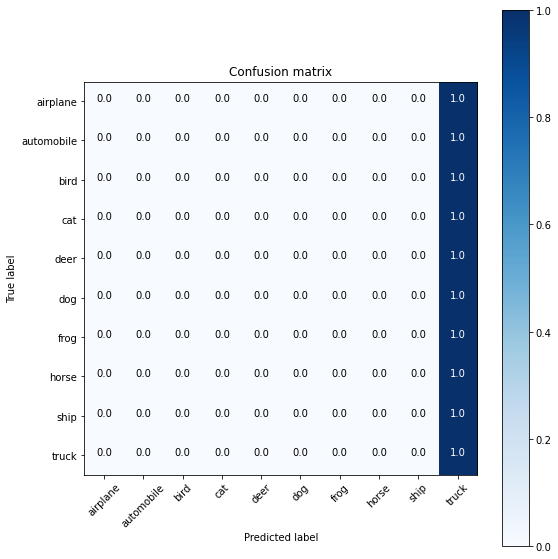

In [15]:
import matplotlib.pyplot as plt
print("Test accuracy:")
accuracy = metrics.accuracy_score(labels, predictions)
print(accuracy)

fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(labels, predictions, categories, ax)

## Tasks and Questions